In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,Dense,Dot, Reshape, Concatenate, LSTM, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tag_data=pd.read_csv("../data/genome-tags.csv")

VOCAB_SIZE=tag_data.tagId.nunique()

VOCAB_SIZE

1128

In [4]:
train = pd.read_csv("../input/train_user_item.csv")
test = pd.read_csv("../input/test_user_item.csv")
validation = pd.read_csv("../input/validation_user_item.csv")

In [5]:
tag_data

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [6]:
train.rating.value_counts()

3    771407
2    750284
1    279800
4    214181
0    133120
Name: rating, dtype: int64

In [7]:
glove_embeddings=pd.read_csv("../input/Glove.csv",index_col=0)

In [8]:
import re

In [9]:
tag_data["tag"]=tag_data["tag"].apply(lambda x: re.sub("[^a-zA-Z\s]","",x))

In [10]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [11]:
tokenizer=Tokenizer(num_words=VOCAB_SIZE)

In [12]:
tokenizer.fit_on_texts(tag_data["tag"])

In [13]:
word_index=tokenizer.word_index

In [14]:
word_index["imdb"]

663

In [15]:
def create_embedding_matrix(word_index_map,embeddings):
    embedding_matrix=np.zeros((len(word_index_map)+1,embeddings.shape[1]))
    c=0
    for word, index in word_index_map.items():
        embedding_vector=None
        try:
            embedding_vector = embeddings.loc[word]
        except KeyError:
            embedding_vector=None
            c+=1
        if embedding_vector is not None:
            embedding_matrix[index, :] = embedding_vector
    print(f"Could not embed {c} words")
    return embedding_matrix

In [16]:
word_index["frombook"]

241

In [17]:
len(word_index)

1155

In [18]:
glove_embeddings.loc["user"]

0    -0.53900
1     0.03310
2     0.52300
3     0.02669
4     0.61960
       ...   
95    0.02710
96   -0.01747
97   -0.87800
98    0.53800
99   -0.29610
Name: user, Length: 100, dtype: float64

In [19]:
word_index

{'best': 1,
 'oscar': 2,
 'good': 3,
 'war': 4,
 'movie': 5,
 'bad': 6,
 'nudity': 7,
 'based': 8,
 'on': 9,
 'comedy': 10,
 'the': 11,
 'plot': 12,
 'great': 13,
 's': 14,
 'ending': 15,
 'music': 16,
 'funny': 17,
 'world': 18,
 'a': 19,
 'book': 20,
 'story': 21,
 'dialogue': 22,
 'action': 23,
 'comic': 24,
 'of': 25,
 'film': 26,
 'dark': 27,
 'fantasy': 28,
 'family': 29,
 'effects': 30,
 'relationship': 31,
 'new': 32,
 'alternate': 33,
 'history': 34,
 'cinematography': 35,
 'soundtrack': 36,
 'acting': 37,
 'science': 38,
 'sequel': 39,
 'video': 40,
 'game': 41,
 'and': 42,
 'drama': 43,
 'cult': 44,
 'as': 45,
 'scifi': 46,
 'life': 47,
 'love': 48,
 'notable': 49,
 'original': 50,
 'space': 51,
 'time': 52,
 'adaptation': 53,
 'adapted': 54,
 'afi': 55,
 'reality': 56,
 'civil': 57,
 'animated': 58,
 'animation': 59,
 'cgi': 60,
 'script': 61,
 'true': 62,
 'tv': 63,
 'better': 64,
 'school': 65,
 'brothers': 66,
 'business': 67,
 'abuse': 68,
 'classic': 69,
 'america': 70

In [20]:
embedding_matrix=create_embedding_matrix(word_index,glove_embeddings)

Could not embed 25 words


In [21]:
tokenizer

In [22]:

def create_sequences(data, label="rating"):
    data.dropna(inplace=True)
    user_tags = tokenizer.texts_to_sequences(data["user_tags"].tolist())
    movie_tags = tokenizer.texts_to_sequences(data["movie_tags"].tolist())
    labels = data[label]
    
    user_tags = pad_sequences(user_tags,maxlen=8)
    movie_tags = pad_sequences(movie_tags, maxlen=16)
    return user_tags, movie_tags, labels

In [23]:
user_input, movie_input, labels = create_sequences(train.sample(5))

In [24]:
train_user, train_movie, train_y=create_sequences(train)
test_user, test_movie, test_y=create_sequences(test)

validation_user, validation_movie, validation_y=create_sequences(validation)

In [25]:
user_input

array([[ 533,   31, 1111,   31,  124,  199,  182,  183],
       [   0,    0,    0,    0,  806,  114,  138,   59],
       [ 202,   72,  120,    8,    9,   62,   21, 1014],
       [   0,    0,    0,    0,    0,    0,  114,  380],
       [ 229,  959,   93,   30,   81,   54,  241,  711]])

In [25]:
movie_input

array([[ 711,  752,  753,   83, 1127,  114,  312,   80,   11,   28,   11,
          80,  929,   52,   94, 1062],
       [ 383,  384,  750,  112,   36,    1,   82,   82,   10,  958,   16,
         115,   14,   17,   36,   14],
       [ 711,   80,  488,   26,   25,    8,    9,   19,   20,  235,  103,
          26,   28,  431,   50,    4],
       [   3,  218,    6,   73,   44,   69,   44,   26,  235,  939,  359,
         217,    6,  218,   17,  260],
       [ 100,    8,    9,   19,   20,  320,   48,  748,  302,   36,  141,
          68,  897,   65,  212,  100]])

In [26]:
from tensorflow.keras import Sequential, Model, layers

In [27]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100

In [28]:
def create_model(embedding_size=16):
    user_tag=Input(name="user_tags",shape=[8])
    movie_tag=Input(name="movie_tags",shape=[16])
    
    glove_embeddings = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=8, trainable=True)
    user_tag_vectors = glove_embeddings(user_tag)
    movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  layers.Average()
    
    user_embedding = average_layer(user_tag_vectors)
    movie_embedding = average_layer(movie_tag_vectors)

    merged = Concatenate(name = 'merge_user_and_movie')([user_embedding, movie_embedding])
    merged=Dense(400, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    out = Dense(6, activation="softmax")(merged)

    model = Model(inputs = [user_tag, movie_tag], outputs = out)
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [29]:
model = create_model()

# model.add(layers.Average())

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             115600      ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 tf.unstack (TFOpLambda)        [(None, 100),        0           ['embedding[0][0]']          

In [32]:
prediction = model.predict([user_input, movie_input])

In [33]:
prediction

array([[0.17705613, 0.20627823, 0.08425603, 0.16995053, 0.12217595,
        0.2402832 ],
       [0.12623236, 0.20634028, 0.1436    , 0.20044583, 0.12596844,
        0.1974131 ],
       [0.26084533, 0.15461814, 0.08403184, 0.17173257, 0.16882987,
        0.1599422 ],
       [0.128352  , 0.20989962, 0.14277054, 0.17251211, 0.18264921,
        0.16381653],
       [0.20001425, 0.22099237, 0.09071527, 0.14184774, 0.14386098,
        0.20256935]], dtype=float32)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath='models/glove_embeddings_finetuned_model/model_{val_loss:.4f}_acc_{val_accuracy:.3f}.h5', monitor='val_loss')

In [36]:
history=model.fit(
    x=[train_user,train_movie],
    y=train_y,
    batch_size=1024,
    validation_data=([validation_user,validation_movie],validation_y),
    # class_weights=class_weights,
    callbacks=[early_stop,checkpoint],
    epochs=500)

Epoch 1/500
2099/2099 [==============================] - 45s 21ms/step - loss: 1.3142 - accuracy: 0.4300 - val_loss: 1.2895 - val_accuracy: 0.4417
Epoch 2/500
   9/2099 [..............................] - ETA: 32s - loss: 1.2809 - accuracy: 0.4446

c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2099/2099 [==============================] - 43s 20ms/step - loss: 1.2744 - accuracy: 0.4479 - val_loss: 1.2578 - val_accuracy: 0.4552
Epoch 3/500
2099/2099 [==============================] - 43s 20ms/step - loss: 1.2435 - accuracy: 0.4619 - val_loss: 1.2297 - val_accuracy: 0.4663
Epoch 4/500
2099/2099 [==============================] - 43s 20ms/step - loss: 1.2228 - accuracy: 0.4708 - val_loss: 1.2134 - val_accuracy: 0.4749
Epoch 5/500
2099/2099 [==============================] - 43s 21ms/step - loss: 1.2079 - accuracy: 0.4772 - val_loss: 1.2045 - val_accuracy: 0.4784
Epoch 6/500
2099/2099 [==============================] - 43s 20ms/step - loss: 1.1963 - accuracy: 0.4820 - val_loss: 1.1897 - val_accuracy: 0.4852
Epoch 7/500
2099/2099 [==============================] - 43s 20ms/step - loss: 1.1862 - accuracy: 0.4861 - val_loss: 1.1805 - val_accuracy: 0.4892
Epoch 8/500
2099/2099 [==============================] - 43s 20ms/step - loss: 1.1777 - accuracy: 0.4897 - val_loss: 1.1726 - val_

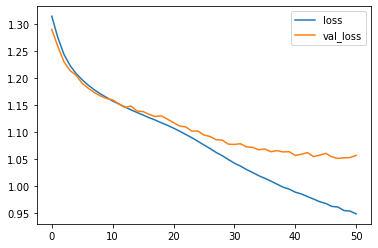

In [37]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

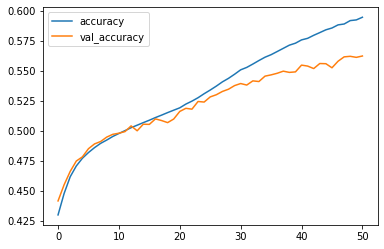

In [38]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])

In [39]:
model.evaluate(
    x=[test_user,test_movie],
    y=test_y,
    batch_size=1024,
    )

1615/1615 [==============================] - 12s 7ms/step - loss: 1.0561 - accuracy: 0.5623


[1.0561403036117554, 0.5622954964637756]

In [40]:
predictions = model.predict([test_user,test_movie])

In [41]:
y_pred = np.argmax(predictions, axis=1)

In [42]:
y_pred

array([1, 1, 2, ..., 2, 3, 2], dtype=int64)

In [43]:
from sklearn.metrics import classification_report, recall_score, ndcg_score, mean_squared_error

In [44]:
print(classification_report(test_y, y_pred))

c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.57      0.45      0.50    102701
           1       0.54      0.30      0.38    215299
           2       0.54      0.64      0.59    576074
           3       0.58      0.66      0.62    593951
           4       0.61      0.35      0.45    164880
           5       0.00      0.00      0.00         0

    accuracy                           0.56   1652905
   macro avg       0.47      0.40      0.42   1652905
weighted avg       0.56      0.56      0.55   1652905



c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
def create_user_embedding_generator(classifier):
    user_tag, _ = classifier.inputs
    
    glove_embeddings = classifier.get_layer("embedding")
    user_tag_vectors = glove_embeddings(user_tag)
    # movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    # movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  classifier.get_layer("average")
    
    user_embedding = average_layer(user_tag_vectors)
    # movie_embedding = average_layer(movie_tag_vectors)

    model = Model(inputs = user_tag, outputs = user_embedding)
    
    # optimizer = tf.keras.optimizers.Adam()
    
    # model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [63]:
def create_movie_embedding_generator(classifier):
    _ , movie_tag = classifier.inputs
    
    glove_embeddings = classifier.get_layer("embedding")
    # user_tag_vectors = glove_embeddings(user_tag)
    movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    # user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  classifier.get_layer("average")
    
    # user_embedding = average_layer(user_tag_vectors)
    movie_embedding = average_layer(movie_tag_vectors)

    model = Model(inputs = movie_tag, outputs = movie_embedding)
    
    # optimizer = tf.keras.optimizers.Adam()
    
    # model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [32]:
model.load_weights("./models/glove_embeddings_finetuned_model/model_1.0505_acc_0.562.h5")

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             115600      ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 tf.unstack (TFOpLambda)        [(None, 100),        0           ['embedding[0][0]']          

In [64]:
user_model = create_user_embedding_generator(model)

In [65]:
user_input

array([[1012,  690,   10,   69,  167, 1022,    5,  861],
       [1026,  190,  959,  372,  764,   13,   15,   50],
       [ 113,  895,   58,  272,    5,  220, 1047,  398],
       [ 294,  483,  217,    6,  218,   17,  441,  115],
       [   0, 1026,  135,  372,  764,   13,   15,   50]])

In [52]:
user_meta_data = pd.read_csv("../data/user_metadata.csv")

In [53]:
movie_meta_data = pd.read_csv("../data/movie_metadata.csv")

In [55]:
movie_meta_data

,movieId,tag
0,1,Owned|imdb top 250|Pixar|Pixar|time travel|chi...
1,2,Robin Williams|time travel|fantasy|based on ch...
2,3,funny|best friend|duringcreditsstinger|fishing...
3,4,based on novel or book|chick flick|divorce|int...
4,5,aging|baby|confidence|contraception|daughter|g...
...,...,...
45246,208813,might like
45247,208933,black and white|deal with the devil
45248,209035,computer animation|Japan|mass behavior|mass sc...
45249,209037,chameleon|computer animation|gluttony|humorous...


In [56]:
users = user_meta_data["user_tags"]
movies = movie_meta_data["tag"]

In [58]:
user_tags = tokenizer.texts_to_sequences(users.tolist())
movie_tags = tokenizer.texts_to_sequences(movies.tolist())

In [60]:
user_tags = pad_sequences(user_tags,maxlen=8)
movie_tags = pad_sequences(movie_tags, maxlen=16)

In [70]:
user_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             115600      ['user_tags[0][0]']              
                                                                                                  
 tf.unstack_4 (TFOpLambda)      [(None, 100),        0           ['embedding[4][0]']              
                                 (None, 100),                                                     
                                 (None, 100),                                                     
                                 (None, 100),                                               

In [72]:
user_input

array([[1012,  690,   10,   69,  167, 1022,    5,  861],
       [1026,  190,  959,  372,  764,   13,   15,   50],
       [ 113,  895,   58,  272,    5,  220, 1047,  398],
       [ 294,  483,  217,    6,  218,   17,  441,  115],
       [   0, 1026,  135,  372,  764,   13,   15,   50]])

In [77]:
user_embeddings=[]
for u in user_tags:
    # print(np.array([u]).shape)
    embedding = user_model.predict(np.array([u]))
    user_embeddings.append(embedding)

In [78]:
movie_model = create_movie_embedding_generator(model)

In [79]:
movie_embeddings=[]
for u in movie_tags:
    # print(np.array([u]).shape)
    embedding = movie_model.predict(np.array([u]))
    movie_embeddings.append(embedding)

In [82]:
len(user_embeddings)

10825

In [92]:
np.reshape(np.array(user_embeddings), (10825,100)).shape

(10825, 100)

In [97]:
user_embedding_df = pd.DataFrame(np.reshape(np.array(user_embeddings), (10825,100)), index=user_meta_data["userId"])
user_embedding_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
userId,,,,,,,,,,,,,,,,,,,,,
3,-0.121341,-0.125917,0.085673,0.038381,0.077507,-0.147435,0.084200,-0.119273,-0.049692,0.092903,...,-0.094062,0.176636,-0.061286,-0.047820,0.015028,-0.107929,0.086117,-0.080702,0.036846,0.118880
4,-0.102689,0.103419,0.010827,0.323775,0.039645,-0.271554,-0.150367,-0.239236,-0.018826,-0.231409,...,-0.048773,-0.190486,-0.329652,0.190306,0.022504,0.148208,-0.241141,-0.325945,0.036916,0.369052
19,-0.023533,-0.317466,-0.084752,-0.033595,-0.004866,-0.175953,-0.062100,-0.123853,0.015007,0.284338,...,0.427892,0.187108,0.181313,-0.320931,0.428260,0.181251,-0.138753,0.059998,0.308398,-0.273252
20,-0.053405,0.011198,-0.006092,0.080694,0.052613,-0.144951,0.062522,0.022935,0.038711,0.015503,...,-0.023501,0.000556,-0.013493,0.035494,0.027715,-0.050210,0.019359,0.057628,0.002154,-0.015680
68,-0.023609,0.007899,-0.058914,0.084986,0.194303,-0.058783,0.102594,-0.006639,-0.021614,0.071474,...,-0.030583,0.006105,-0.037921,0.103596,0.014820,-0.040098,-0.037179,0.012789,0.016486,0.102540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162467,-0.204419,-0.048375,-0.090326,-0.171004,-0.184930,-0.093621,0.079045,0.011678,0.097479,-0.040047,...,0.097885,-0.044462,0.050842,0.066535,0.026851,-0.099415,-0.025332,0.176026,0.145395,-0.193791
162492,0.146008,-0.071524,0.065718,0.047543,0.182813,-0.133984,0.044468,-0.091367,-0.015241,0.042442,...,0.029203,0.317145,-0.148624,-0.037098,0.043106,-0.145035,0.127140,-0.007914,-0.135165,0.106798
162501,-0.013175,-0.243947,0.084938,-0.132431,0.005760,0.179449,-0.166607,0.096545,0.177472,-0.015738,...,-0.014525,-0.133780,-0.023970,-0.028825,0.038200,-0.069904,-0.087183,0.093241,0.018613,-0.089881


In [98]:
np.array(movie_embeddings).shape

(45251, 1, 100)

In [99]:
movie_embedding_df = pd.DataFrame(np.reshape(np.array(movie_embeddings), (45251,100)), index=movie_meta_data["movieId"])
movie_embedding_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.593047,0.033794,0.048042,0.134441,0.506332,-0.290345,-0.028565,-0.384276,0.136517,-0.148973,...,0.107009,0.016879,0.516428,-0.091853,-0.159012,-0.362357,0.104021,-0.027608,0.272703,-0.277563
2,0.209889,0.266159,0.256251,-0.090502,-0.197600,0.407033,0.137838,0.205913,-0.057619,-0.180064,...,-0.099201,0.175423,0.438440,-0.385567,-0.274389,-0.264258,0.010146,0.268159,0.371597,-0.371268
3,0.094308,-0.238787,0.026768,-0.062222,0.103212,-0.093965,0.268620,0.229196,0.109590,-0.273120,...,-0.069267,-0.055471,0.076947,0.038989,-0.178510,0.106657,-0.195120,0.102197,-0.122369,-0.096146
4,0.047895,0.077032,-0.354608,-0.255282,-0.257211,0.592242,0.024765,0.028484,0.507291,0.008162,...,-0.042577,0.179383,0.099735,-0.027250,0.244542,-0.214361,0.098254,-0.129777,0.066947,-0.016165
5,0.356860,-0.121125,0.262100,0.045333,-0.288044,0.302943,0.025113,-0.010468,0.158689,-0.098469,...,0.097676,0.173685,0.345943,-0.052000,-0.030655,0.185006,0.069091,0.184781,-0.044920,-0.220905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208813,-0.097420,-0.074152,0.025697,0.019317,-0.034601,-0.044151,-0.051807,0.047489,0.153688,-0.015702,...,-0.015584,-0.081164,-0.012070,-0.102875,0.049942,-0.050385,0.010373,0.170597,-0.005364,-0.077852
208933,-0.135204,0.058925,0.040108,-0.171874,-0.012750,-0.016764,-0.072382,0.034830,0.067799,-0.002493,...,-0.050237,-0.325632,-0.069068,-0.055653,-0.174641,-0.193955,-0.332542,0.109513,0.062132,-0.175021
209035,-0.099222,0.021947,0.042990,0.096232,0.007968,-0.094830,-0.106738,-0.019215,0.051752,0.037721,...,0.214699,-0.060750,0.100028,-0.165911,0.253974,-0.181411,-0.020588,0.134096,0.082989,-0.185959


In [100]:
user_embedding_df.to_csv("../output/user_embeddings.csv")
movie_embedding_df.to_csv("../output/movie_embeddings.csv")